In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
AGENT = 1
OPPONENT = -1
NO_PLAYER = 0

In [3]:
class Game:    
    def __init__(self, game_state=None):
        # инициализация состояния игры
        if game_state is None:
            game_state = [
                0, 0, 0,
                0, 0, 0,
                0, 0, 0
            ]
        self.state = game_state
    
    def __str__(self):
        return str(self.state)

    def is_draw(self):
        return len([field for field in self.state if field == NO_PLAYER]) == 0

    def is_finished(self):
        return self.get_winner() != NO_PLAYER or self.is_draw()

    def valid_moves(self):
        # получение списка допустимых ходов
        return [i for i in range(9) if self.state[i] == NO_PLAYER]

    def make_move(self, field, player):
        next = list(self.state)
        next[field] = player
        return Game(next)

    def get_winner(self):
        state = self.state
        # определение победителя игры (по горизонтали, вертикали или диагоналям)
        for i in range(3):
            if state[i * 3] == state[i * 3 + 1] == state[i * 3 + 2] == state[i * 3] != NO_PLAYER:
                return state[i * 3]
            if state[i] == state[i + 3] == state[i + 6] == state[i] != NO_PLAYER:
                return state[i]
            if state[0] == state[4] == state[8] == state[0] != NO_PLAYER:
                return state[0]
            if state[2] == state[4] == state[6] == state[2] != NO_PLAYER:
                return state[2]

        return NO_PLAYER

In [4]:
# игра
def play_games(policy, opponent_policy, num_games=100):
    games_won = 0
    draw = 0
    for i in range(num_games):
        game = Game()
        if random.random() > 0.5:
            game = game.make_move(opponent_policy(game), OPPONENT)

        while not game.is_finished():
            game = game.make_move(policy(game), AGENT)
            if game.is_finished():
                break
            game = game.make_move(opponent_policy(game), OPPONENT)

        if game.get_winner() == 0:
            draw = draw + 1
        if game.get_winner() > 0:
            games_won = games_won + 1

    return games_won, draw

In [5]:
# стратегия агента
class ValuePolicy:
    DEFAULT_VALUE = 0.5 # начальное значение для каждого состояния

    def __init__(self):
        self.values = {}

    def policy(self, game):
        # возвращает ход с наибольшим значением состояния
        move_values = {}
        moves = game.valid_moves()
        for move in moves:
            next = game.make_move(move, AGENT)
            move_values[move] = self.get_state_value(next)

        return max(move_values, key=move_values.get)

    def get_state_value(self, state):
        if str(state) not in self.values:
            return self.DEFAULT_VALUE

        return self.values[str(state)]

    def set_state_value(self, state, value):
        self.values[str(state)] = value

    def learn(self, states):
        # метод обучения стратегии на основе состояний
        def temporal_difference(current_state_value, next_state_value):
            learning_rate = 0.1
            return current_state_value + learning_rate * (next_state_value - current_state_value)

        last_state = states[-1:][0]
        last_value = reward(last_state)
        self.set_state_value(last_state, last_value)

        for state in reversed(states[:-1]):
            value = self.get_state_value(state)
            last_value = temporal_difference(value, last_value)
            self.set_state_value(state, last_value)

In [6]:
# стратегия случайного выбора хода
def random_policy(game):
    return random.choice(game.valid_moves())

In [7]:
def reward(state):
    winner = state.get_winner()
    if winner == AGENT:
        return 1.0
    elif winner == OPPONENT:
        return 0.0
    elif state.is_draw():
        return 0.5
    else:
        return 0.5

In [8]:
# оценка стратегии агента
def evaluate_performance(policy, opponent_policy, num_games=100):
    games_won = 0
    draws = 0
    for _ in range(num_games):
        game = Game()
        if random.random() > 0.5:
            game = game.make_move(opponent_policy(game), OPPONENT)
            
        while not game.is_finished():
            game = game.make_move(policy.policy(game), AGENT)
            if game.is_finished():
                break
            game = game.make_move(opponent_policy(game), OPPONENT)
            
        if game.get_winner() == 0:
            draws += 1
        elif game.get_winner() > 0:
            games_won += 1
            
    return (games_won + draws * 0.5) / num_games

In [9]:
def train(policy, opponent_policy, training_games=1000):
    for i in range(training_games):
        game = Game()
        states = []

        if random.random() > 0.5:
            game = game.make_move(opponent_policy(game), OPPONENT)

        while not game.is_finished():
            if random.random() < 0.5:
                game = game.make_move(random_policy(game), AGENT)
            else:
                game = game.make_move(policy.policy(game), AGENT)
            states.append(game)

            if game.is_finished():
                break

            game = game.make_move(opponent_policy(game), OPPONENT)
            states.append(game)

        policy.learn(states)

In [19]:
def train_and_plot(policy, opponent_policy, total_training_games=5000, eval_interval=100):
    performance_history = []
    
    for i in range(0, total_training_games, eval_interval):
        train(policy, opponent_policy, training_games=eval_interval)
        
        performance = evaluate_performance(policy, opponent_policy, num_games=100)
        performance_history.append(performance)
        
        print(f"Прогресс обучения: {i+eval_interval}/{total_training_games}, Эффективность: {performance:.2f}")
    
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(len(performance_history)) * eval_interval, performance_history)
    plt.title('Кривая обучения')
    plt.xlabel('Количество тренировочных игр')
    plt.ylabel('Эффективность')
    plt.grid(True)
    plt.savefig('plot.png')
    plt.show()

Прогресс обучения: 100/30000, Эффективность: 0.64
Прогресс обучения: 200/30000, Эффективность: 0.69
Прогресс обучения: 300/30000, Эффективность: 0.64
Прогресс обучения: 400/30000, Эффективность: 0.65
Прогресс обучения: 500/30000, Эффективность: 0.78
Прогресс обучения: 600/30000, Эффективность: 0.69
Прогресс обучения: 700/30000, Эффективность: 0.67
Прогресс обучения: 800/30000, Эффективность: 0.74
Прогресс обучения: 900/30000, Эффективность: 0.81
Прогресс обучения: 1000/30000, Эффективность: 0.71
Прогресс обучения: 1100/30000, Эффективность: 0.77
Прогресс обучения: 1200/30000, Эффективность: 0.80
Прогресс обучения: 1300/30000, Эффективность: 0.84
Прогресс обучения: 1400/30000, Эффективность: 0.82
Прогресс обучения: 1500/30000, Эффективность: 0.79
Прогресс обучения: 1600/30000, Эффективность: 0.86
Прогресс обучения: 1700/30000, Эффективность: 0.75
Прогресс обучения: 1800/30000, Эффективность: 0.86
Прогресс обучения: 1900/30000, Эффективность: 0.87
Прогресс обучения: 2000/30000, Эффективн

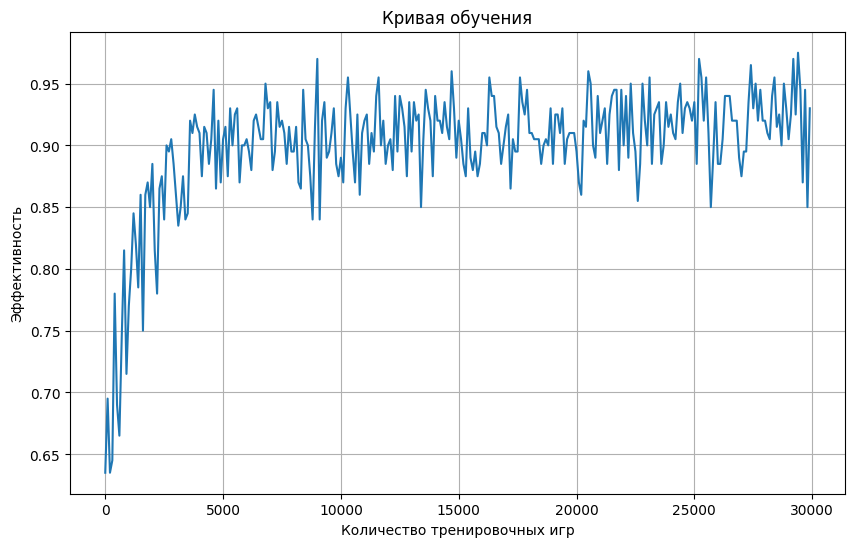

In [21]:
policy = ValuePolicy()
train_and_plot(policy, random_policy, total_training_games=30000, eval_interval=100)